# AlexCapsNet - Final Fixed Version

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(0)

In [2]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:11<00:00, 842519.07it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 130978.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:06<00:00, 272667.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 12708825.06it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class CapsuleLayer(nn.Module):
    def __init__(self, in_capsules, in_dim, out_capsules, out_dim, num_routing=3):
        super(CapsuleLayer, self).__init__()
        self.in_capsules = in_capsules
        self.out_capsules = out_capsules
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_routing = num_routing
        self.W = nn.Parameter(torch.randn(1, in_capsules, out_capsules, out_dim, in_dim) * 0.01)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(2).unsqueeze(-1)  # [b, in_caps, 1, in_dim, 1]
        u_hat = torch.matmul(self.W, x).squeeze(-1)  # [1, in_caps, out_caps, out_dim] -> broadcasted to [b, in_caps, out_caps, out_dim]
        b_ij = torch.zeros(batch_size, self.in_capsules, self.out_capsules, device=x.device)

        for r in range(self.num_routing):
            c_ij = F.softmax(b_ij, dim=-1).unsqueeze(-1)
            s_j = (c_ij * u_hat).sum(dim=1)
            v_j = self.squash(s_j)
            if r < self.num_routing - 1:
                b_ij = b_ij + (u_hat * v_j.unsqueeze(1)).sum(dim=-1)
        return v_j

    def squash(self, s, eps=1e-9):
        s_norm_sq = (s ** 2).sum(dim=-1, keepdim=True)
        return (s_norm_sq / (1 + s_norm_sq)) * (s / torch.sqrt(s_norm_sq + eps))

In [5]:
class AlexCapsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.primary_caps = nn.Conv2d(256, 32 * 8, kernel_size=1, stride=1)
        self.digit_caps = CapsuleLayer(in_capsules=128, in_dim=8, out_capsules=10, out_dim=16, num_routing=3)

    def forward(self, x):
        x = self.features(x)
        x = self.primary_caps(x)
        b = x.size(0)
        x = x.view(b, 32, 8, 2, 2).permute(0, 1, 3, 4, 2).contiguous().view(b, -1, 8)
        v = self.digit_caps(x)
        lengths = torch.norm(v, dim=-1)
        return lengths
model = AlexCapsNet().to(device)

In [6]:
def margin_loss(lengths, labels, m_plus=0.9, m_minus=0.1, lambda_val=0.5):
    one_hot = torch.eye(10, device=device).index_select(0, labels)
    loss_pos = one_hot * F.relu(m_plus - lengths) ** 2
    loss_neg = (1.0 - one_hot) * F.relu(lengths - m_minus) ** 2
    return (loss_pos + lambda_val * loss_neg).sum(dim=1).mean()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
train_losses, test_losses, train_accs, test_accs = [], [], [], []
for epoch in range(10):
    model.train()
    running_loss, correct = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = margin_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accs.append(correct / len(train_loader.dataset))

    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = margin_loss(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    test_losses.append(running_loss / len(test_loader.dataset))
    test_accs.append(correct / len(test_loader.dataset))
    print(f"Epoch {epoch+1}: Train Acc = {train_accs[-1]:.4f}, Test Acc = {test_accs[-1]:.4f}")

Epoch 1: Train Acc = 0.3267, Test Acc = 0.6517
Epoch 2: Train Acc = 0.8749, Test Acc = 0.9526
Epoch 3: Train Acc = 0.9540, Test Acc = 0.9633
Epoch 4: Train Acc = 0.9628, Test Acc = 0.9684
Epoch 5: Train Acc = 0.9669, Test Acc = 0.9685
Epoch 6: Train Acc = 0.9702, Test Acc = 0.9686
Epoch 7: Train Acc = 0.9724, Test Acc = 0.9785
Epoch 8: Train Acc = 0.9734, Test Acc = 0.9694
Epoch 9: Train Acc = 0.9754, Test Acc = 0.9773
Epoch 10: Train Acc = 0.9780, Test Acc = 0.9806


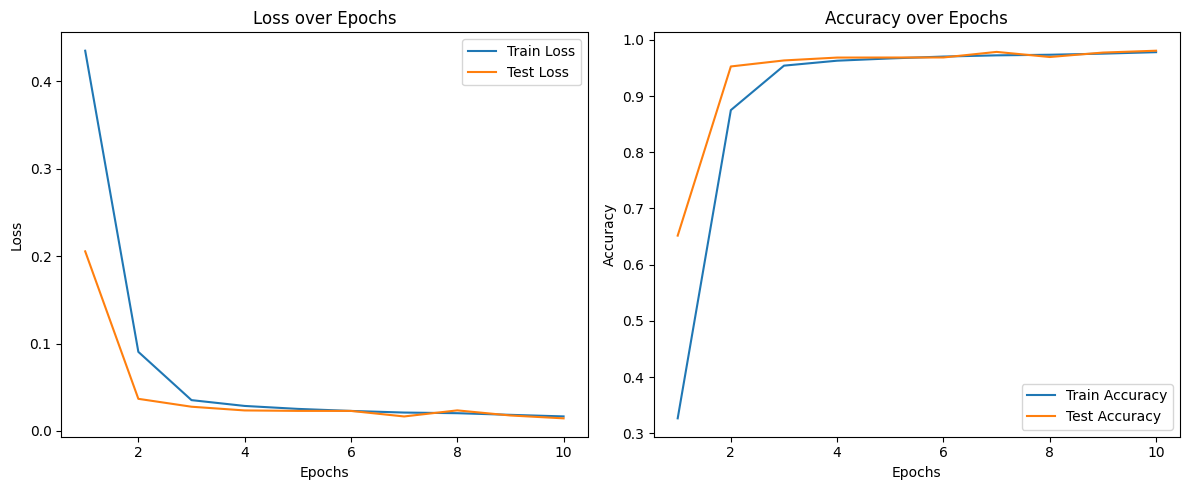

In [8]:
# Plotting training and test loss/accuracy
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

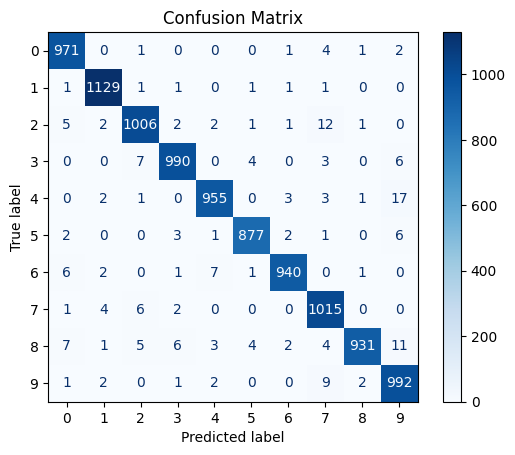

In [9]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()